In [1]:
# General import, names of train, test, val
import numpy as np
import pysam
from tqdm.notebook import tqdm
import h5py
import pandas as pd
import matplotlib.pyplot as plt

basedir = '/data/leslie/shared/ASA/'
aligndir = basedir+'pseudodiploid/'
ctype = 'cd8'
ident = '_vi_150bp'

datadir = basedir+'mouseASA/data/'+ctype+'/'
chrom_train = [1,2,4,6,7,8,9,11,12,13,14,16,17,18,19]
chrom_val = [3,5]
chrom_test = [10,15]
chroms = [chrom_train, chrom_val, chrom_test]
name = ['train', 'val', 'test']

reps = ['r1','r2','r3','r4','r5']
seqlen = 300                         # region around summit for sequence
seqlen1 = 150                        # region around summit for coverage
save = True

# Preprocessing of Model Input

In [2]:
import os
# some utility functions
from utils import get_summits, get_shifts, one_hot, GCregress

# make data directory for the cell type
if not os.path.exists(datadir):
    os.makedirs(datadir)
    # separate out replicate BAM files based on allele tag wA, to be used for pileup purposes
    for rep in reps:
        bamfile = aligndir+ctype+'/'+rep+'.combined.rmDup.Aligned.sortedByCoord.out.bam'
        _ = pysam.index(bamfile)
        bamf = pysam.AlignmentFile(bamfile, "rb")
        temp1 = pysam.AlignmentFile(datadir+rep+'_b6.bam', 'wb', template=bamf)
        temp2 = pysam.AlignmentFile(datadir+rep+'_cast.bam', 'wb', template=bamf)
        temp3 = pysam.AlignmentFile(datadir+rep+'_both.bam', 'wb', template=bamf)
        i=0
        for read in bamf.fetch():
            try:
                idx = read.get_tag('wA')
                if idx==0:
                    temp1.write(read)
                elif idx==1:
                    temp2.write(read)
                elif idx==2:
                    temp3.write(read)
            except:
                i+=1
        print(i)
        temp1.close()
        temp2.close()
        temp3.close()
        bamf.close()

        _ = pysam.index(datadir+rep+'_b6.bam')
        _ = pysam.index(datadir+rep+'_cast.bam')
        _ = pysam.index(datadir+rep+'_both.bam')

N = []
for rep in reps:
    bamfile = aligndir+ctype+'/'+rep+'.combined.rmDup.Aligned.sortedByCoord.out.bam'
    bamf = pysam.AlignmentFile(bamfile, "rb")
    N.append( sum([bamf.get_index_statistics()[i][1] for i in range(len(chrom_train+chrom_test+chrom_val))]) )
    bamf.close()

In [4]:
# process peakatlas file to get peaks dataframe
if ident[:3]=='_vi':
    summits = pd.read_csv(aligndir+'cd8_old/yi_cd8_peaks_33143.csv',sep=',',index_col=0)
    summits['start'] += 150
    temp = summits.iloc[:,0]
    summits = summits.iloc[:,1:3]
    summits.columns = range(2)
    summits_neg = pd.read_csv(aligndir+'cd8_old/yi_cd8_uneg_peaks_33143.csv',sep=',',index_col=0)
    summits_neg['start'] += 150
    summits_neg = summits_neg.iloc[:,1:3].reset_index(drop=True)
    summits_neg.columns = range(2)
else:
    if ident=='_yi':
        peakfile = aligndir+'cd8_old/peaks_yi.bed'
    else:
        peakfile = aligndir+ctype+'/peaks/peakatlas.bed'
    peaks = pd.read_csv(peakfile, sep='\t', header=None)

    if not ident:
        # filter peaks based on IDR threshold (column 12 of BED)
        idr_thresh = 0.05
        idx = np.where( peaks.iloc[:,11] >= -np.log10(idr_thresh) )[0]
        peaks = peaks.loc[idx].reset_index(drop=True)

    # remove blacklist regions
    # blacklistfile = aligndir+'mm10-blacklist.v2.bed'
    # blacklist = pd.read_csv(blacklistfile, sep='\t', header=None)
    # peaks = remove_blacklist(peaks, blacklist)

    # get summits of called + flanking neg peaks
    summits, summits_neg = get_summits(peaks)

In [5]:
if ident[:3]!='_vi':
    # FOR UNEGS, get the shortlist of summits_neg that have low accessibility
    # get indices for each rep
    idx = dict()
    for rep in tqdm(reps):
        bamfile = aligndir+ctype+'/'+rep+'.combined.rmDup.Aligned.sortedByCoord.out.bam'
        bamf = pysam.AlignmentFile(bamfile, "rb")

        idx[rep] = []
        for chrom in chroms[:2]:
            for c in chrom:
                chromsummits = summits_neg.loc[np.where(summits_neg[0]==c)[0]]
                y_uneg = []
                for i in chromsummits[1]:
                    y_uneg.append(bamf.count(str(c),i-seqlen//2,i+seqlen//2))
                idx[rep] += list(chromsummits.index[ np.where(np.array(y_uneg)<5)[0] ])
        bamf.close()

    del y_uneg
    # get low accessibility indices across reps
    temp = set(idx[reps[0]])
    for rep in reps[1:]:
        temp.intersection_update(idx[rep])
    idx = list(temp)

    # shortlist unegs to low accessibility indexes
    summits_neg = summits_neg.loc[idx].reset_index(drop=True)
    frac=0.5
    if len(summits_neg) > frac*len(summits):
        idx = np.random.choice(len(summits_neg), int(frac*len(summits)), replace=False)
        summits_neg = summits_neg.loc[idx].reset_index(drop=True)
    summits_neg = summits_neg.sort_values(by=[0,1], ignore_index=True)

    if save:
        summits.to_csv(datadir+'summits'+ident+'.csv', index=False, header=False)
        summits_neg.to_csv(datadir+'summits_neg'+ident+'.csv', index=False, header=False)

In [12]:
# Generate y
# Use summits and BAM files to generate pileup summed accessibilities
dataset = 'both'
y = dict()
for rep in tqdm(reps):
    temp1 = pysam.AlignmentFile(datadir+rep+'_b6.bam', 'rb')
    temp2 = pysam.AlignmentFile(datadir+rep+'_cast.bam', 'rb')
    temp3 = pysam.AlignmentFile(datadir+rep+'_both.bam', 'rb')

    for n,chrom in zip(name,chroms):
        y[rep+'_'+n+'_b6'] = []
        y[rep+'_'+n+'_cast'] = []

        for c in chrom:        # for each chromosome in train/val/test set
            chromsummits = summits.loc[np.where(summits[0]==c)[0],1]     # slice out the relevant chromosome summits
            y_b6 = []
            y_cast = []
            for i in chromsummits:
                # for each summit peak, get the summed accessibility from BAM pileup
                y1 = temp1.count(str(c),i-seqlen1//2,i+seqlen1//2)
                y2 = temp2.count(str(c),i-seqlen1//2,i+seqlen1//2)
                y3 = temp3.count(str(c),i-seqlen1//2,i+seqlen1//2)
                y_b6.append(y1+y3/2)
                y_cast.append(y2+y3/2)            
            
            y[rep+'_'+n+'_b6'] += y_b6
            y[rep+'_'+n+'_cast'] += y_cast
    
    temp1.close()
    temp2.close()
    temp3.close()
    
del y_b6, y_cast, y1, y2, y3, chromsummits

# merge RPMs across reps
for n in name:
    y[n+'_b6'] = np.zeros_like(y[rep+'_'+n+'_b6'])
    y[n+'_cast'] = np.zeros_like(y[rep+'_'+n+'_cast'])
    for i,rep in enumerate(reps):
        y[n+'_b6'] += np.array(y[rep+'_'+n+'_b6'])*1e6/N[i]
        y[n+'_cast'] += np.array(y[rep+'_'+n+'_cast'])*1e6/N[i]
        del y[rep+'_'+n+'_b6'], y[rep+'_'+n+'_cast']

if dataset=='both':
    for n in name:
        y[n+'_b6'] = np.log2( 1+y[n+'_b6'] )                  # normalize summed counts to RPM
        y[n+'_cast'] = np.log2( 1+y[n+'_cast'] )                  # normalize summed counts to RPM
elif dataset=='ref':
    for n in name:
        y[n] = np.log2( 1+y[n+'_b6']+y[n+'_cast'] )      # normalize summed counts to RPM
        del y[n+'_b6'], y[n+'_cast']

# set uneg log acc to low constant value
for n,chrom in zip(name[:2],chroms[:2]):
    y[n+'_unegs'] = -5.0*np.ones(len(summits_neg.loc[np.where(summits_neg[0].isin(chrom))[0]]))

if dataset=='both':
    if save:
        with h5py.File(datadir+'data_noGC'+ident+'.h5','w') as f:
            for key in y.keys():
                f.create_dataset('y_'+key, data=y[key])
elif dataset=='ref':
    if save:
        with h5py.File(datadir+'data_noGC'+ident+'_ref.h5','w') as f:
            for key in y.keys():
                f.create_dataset('y_'+key, data=y[key])

  0%|          | 0/5 [00:00<?, ?it/s]

In [14]:
# Generate X
# Get coordinate shifts for the cast genome corresponding to the summits in b6 coords, and prepare input homologous peak sequences X
import gzip
from Bio import SeqIO
from bisect import bisect

gen_b6 = SeqIO.index(aligndir+'gen/b6.fa', 'fasta')
gen_cast = SeqIO.index(aligndir+'gen/cast.fa', 'fasta')

modfile = aligndir+'gen/cast.mod'
with gzip.open(modfile,'rt') as f:
    mods = f.read().split('\n')
    mods = [x for x in mods if not (x.startswith('s') or x.startswith('#'))][:-1]            # filter out SNPs and header lines

x = dict()
for n,chrom in zip(name,chroms):
    x[n+'_b6'] = []
    x[n+'_cast'] = []
    if n!='test':
        x[n+'_unegs'] = []

    for c in tqdm(chrom):        # for each chromosome in train/val/test set
        seq_b6 = ''.join(gen_b6.get_raw(str(c)).decode().split('\n')[1:])
        seq_cast = ''.join(gen_cast.get_raw(str(c)).decode().split('\n')[1:])

        chromsummits = summits.loc[np.where(summits[0]==c)[0],1]     # slice out the relevant chromosome summits
        cast_shifts = get_shifts(chromsummits, mods, c)

        # get relevant b6 genomic seqs
        x[n+'_b6'] += [seq_b6[i-seqlen//2:i+seqlen//2] for i in chromsummits]
        # add corresponding cast genomic seqs
        x[n+'_cast'] += [seq_cast[i+j-seqlen//2:i+j+seqlen//2] for i,j in zip(chromsummits,cast_shifts)]

        if n!='test':
            chromsummits = summits_neg.loc[np.where(summits_neg[0]==c)[0],1]     # slice out the relevant chromosome summits
            x[n+'_unegs'] += [seq_b6[i-seqlen//2:i+seqlen//2] for i in chromsummits]

    x[n+'_b6'] = one_hot(x[n+'_b6'])             # convert string of nucleotides to one-hot representation
    x[n+'_cast'] = one_hot(x[n+'_cast'])
    if n!='test':
        x[n+'_unegs'] = one_hot(x[n+'_unegs'])

gen_b6.close()
gen_cast.close()

if dataset=='both':
    if save:
        with h5py.File(datadir+'data_noGC'+ident+'.h5','a') as f:
            for key in y.keys():
                f.create_dataset('x_'+key, data=x[key])
elif dataset=='ref':
    for n in name:
        x[n] = x[n+'_b6']
        del x[n+'_b6'], x[n+'_cast']
    if save:
        with h5py.File(datadir+'data_noGC'+ident+'_ref.h5','a') as f:
            for key in y.keys():
                f.create_dataset('x_'+key, data=x[key])

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

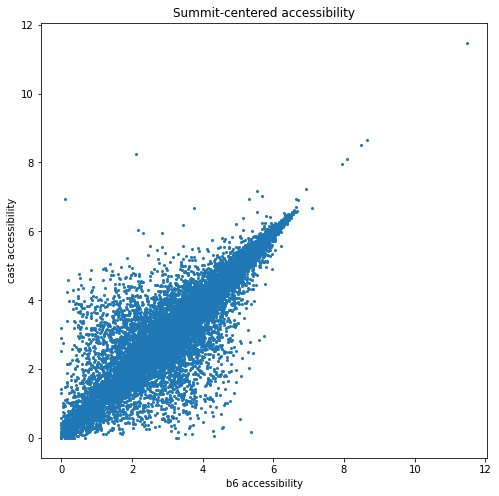

In [3]:
if dataset=='both':
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot()

    ax.scatter(y['train_b6'],y['train_cast'], s=4)
    plt.title('Summit-centered accessibility')
    ax.set_xlabel('b6 accessibility')
    ax.set_ylabel('cast accessibility')
    plt.show()

## Perform GC regression

In [13]:
x = dict()
y = dict()
dataset='both'
if dataset=='both':
    with h5py.File(datadir+'data_noGC'+ident+'.h5','r') as f:
        for n in name:
            for allele in ['b6','cast']:
                x[n+'_'+allele] = f['x_'+n+'_'+allele][()]
                y[n+'_'+allele] = f['y_'+n+'_'+allele][()]
        x['train_unegs'] = f['x_train_unegs'][()]
        x['val_unegs'] = f['x_val_unegs'][()]
        y['train_unegs'] = f['y_train_unegs'][()]
        y['val_unegs'] = f['y_val_unegs'][()]
elif dataset=='ref':
    with h5py.File(datadir+'data_noGC'+ident+'_ref.h5','r') as f:
        for n in name:
            x[n] = f['x_'+n][()]
            y[n] = f['y_'+n][()]
        x['train_unegs'] = f['x_train_unegs'][()]
        x['val_unegs'] = f['x_val_unegs'][()]
        y['train_unegs'] = f['y_train_unegs'][()]
        y['val_unegs'] = f['y_val_unegs'][()]

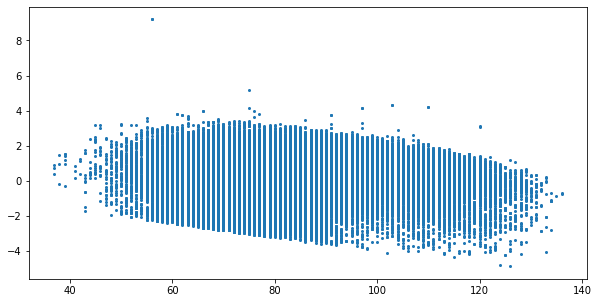

In [4]:
# Visualize the GC-count relationship
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot()

temp_x = np.vstack([x[k] for k in x.keys() if 'unegs' not in k])
temp_y = np.concatenate([y[k] for k in y.keys() if 'unegs' not in k])
GC = np.sum(temp_x[:,(seqlen//2-seqlen1//2):(seqlen//2+seqlen1//2),:], axis=1)
GC = GC[:,1]+GC[:,2]
ax.scatter(GC/seqlen*100, temp_y, s=4)
coef = GCregress(temp_x[:,(seqlen//2-seqlen1//2):(seqlen//2+seqlen1//2),:], temp_y, method='linear')    # limit GC counting to only the window where reads are counted
temp_y -= coef*GC
ax.scatter(GC/seqlen*100, temp_y, s=4)
ax.set_xlabel('GC content (%)')
ax.set_ylabel('log accessibility')
plt.show()

In [73]:
# Regress out GC content
method = 'linear'
temp_x = np.vstack([x[k] for k in x.keys() if 'unegs' not in k])
temp_y = np.concatenate([y[k] for k in y.keys() if 'unegs' not in k])
coef = GCregress(temp_x[:,(seqlen//2-seqlen1//2):(seqlen//2+seqlen1//2),:], temp_y, method)    # limit GC counting to only the window where reads are counted


cnt=0
if dataset=='both':
    for n in name:
        for allele in ['b6','cast']:
            GC = np.sum(x[n+'_'+allele][:,(seqlen//2-seqlen1//2):(seqlen//2+seqlen1//2),:], axis=1)
            GC = GC[:,1]+GC[:,2]
            if method=='linear':
                y[n+'_'+allele] -= coef*GC
            elif method=='spline':
                y[n+'_'+allele] -= coef[cnt:cnt+len(GC)]*GC
                cnt += len(GC)
elif dataset=='ref':
    del x['test'], y['test']
    for n in ['train','val']:
        GC = np.sum(x[n][:,(seqlen//2-seqlen1//2):(seqlen//2+seqlen1//2),:], axis=1)
        GC = GC[:,1]+GC[:,2]
        if method=='linear':
            y[n] -= coef*GC
        elif method=='spline':
            y[n] -= coef[cnt:cnt+len(GC)]*GC
            cnt += len(GC)

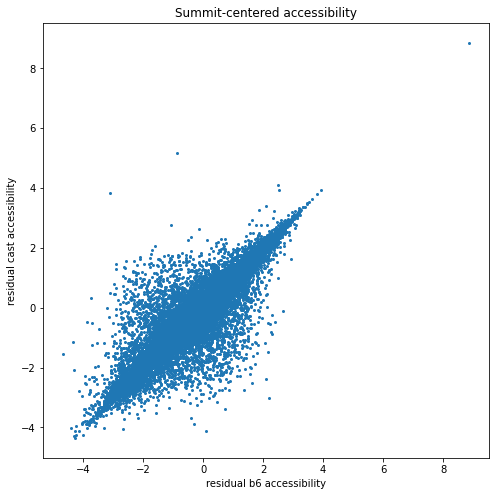

In [65]:
if dataset=='both':
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot()

    ax.scatter(y['train_b6'], y['train_cast'],
                vmax = 2, vmin = -2, s = 4)
    plt.title('Summit-centered accessibility')
    ax.set_xlabel('residual b6 accessibility')
    ax.set_ylabel('residual cast accessibility')
    plt.show()

In [6]:
# Do uneg count adjustment based on range of GC corrected values
np.unique(y['train_unegs'])
# y['train_unegs'] -= 5
# y['val_unegs'] -= 5

array([-5.])

In [78]:
if dataset=='both':
    if save:
        with h5py.File(datadir+'data'+ident+'.h5','w') as f:
            for key in x.keys():
                f.create_dataset('x_'+key, data=x[key])
                f.create_dataset('y_'+key, data=y[key])
elif dataset=='ref':
    if save:
        with h5py.File(datadir+'data'+ident+'_ref.h5','w') as f:
            for key in x.keys():
                f.create_dataset('x_'+key, data=x[key])
                f.create_dataset('y_'+key, data=y[key])